In [97]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [98]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(
    "C:/Users/seren/Downloads/Underwater_Trash/train", 
    shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 300 files belonging to 2 classes.


In [99]:
validation_dataset = image_dataset_from_directory(
    "C:/Users/seren/Downloads/Underwater_Trash/validation",
    shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 160 files belonging to 2 classes.


In [100]:
test_dataset = image_dataset_from_directory(
    "C:/Users/seren/Downloads/Underwater_Trash/test",
    shuffle=True, batch_size=12, image_size=IMG_SIZE)

Found 40 files belonging to 2 classes.


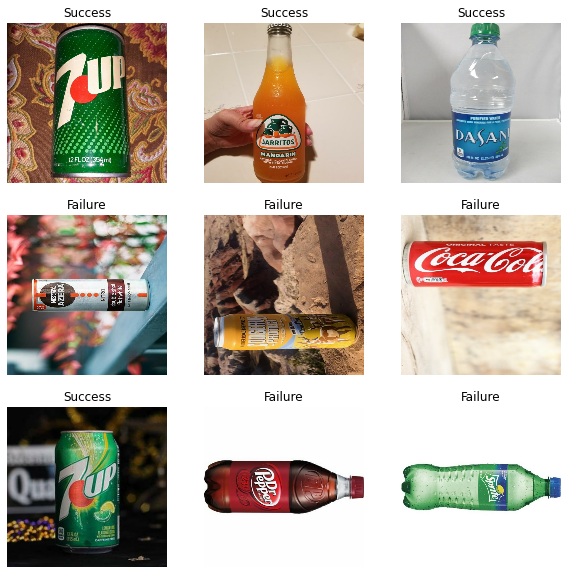

In [101]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [102]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [103]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
#print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4


In [104]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [105]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


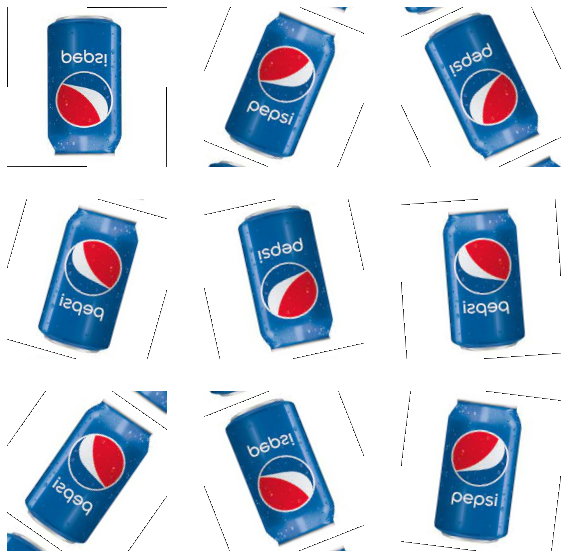

In [106]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [107]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [108]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [109]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [110]:
base_model.trainable = False

In [111]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [112]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [113]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [114]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [115]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [116]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)             

In [117]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 1s 252ms/step - loss: 0.8345 - accuracy: 0.4766


In [118]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.48


In [119]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
10/10 [==============================] - 5s 530ms/step - loss: 0.8709 - accuracy: 0.4567 - val_loss: 0.8078 - val_accuracy: 0.4922
Epoch 2/10
10/10 [==============================] - 5s 541ms/step - loss: 0.8180 - accuracy: 0.5067 - val_loss: 0.7459 - val_accuracy: 0.4922
Epoch 3/10
10/10 [==============================] - 5s 541ms/step - loss: 0.7952 - accuracy: 0.5267 - val_loss: 0.7601 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 6s 627ms/step - loss: 0.8290 - accuracy: 0.5000 - val_loss: 0.7598 - val_accuracy: 0.4844
Epoch 5/10
10/10 [==============================] - 6s 626ms/step - loss: 0.7308 - accuracy: 0.5733 - val_loss: 0.7372 - val_accuracy: 0.5078
Epoch 6/10
10/10 [==============================] - 6s 566ms/step - loss: 0.7194 - accuracy: 0.5800 - val_loss: 0.6656 - val_accuracy: 0.5625
Epoch 7/10
10/10 [==============================] - 6s 566ms/step - loss: 0.7392 - accuracy: 0.5500 - val_loss: 0.6529 - val_accuracy: 0.5703
Epoch 

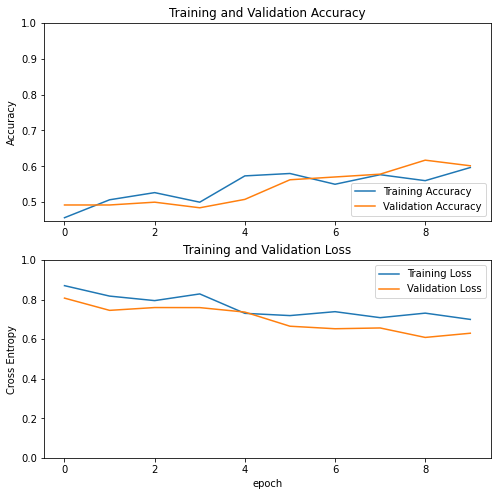

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [121]:
base_model.trainable = True

In [122]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [123]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [124]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)             

In [125]:
len(model.trainable_variables)

58

In [126]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
10/10 [==============================] - 8s 841ms/step - loss: 0.5506 - accuracy: 0.7067 - val_loss: 0.3195 - val_accuracy: 0.8594
Epoch 11/20
10/10 [==============================] - 7s 744ms/step - loss: 0.3618 - accuracy: 0.8133 - val_loss: 0.2007 - val_accuracy: 0.9531
Epoch 12/20
10/10 [==============================] - 8s 752ms/step - loss: 0.2502 - accuracy: 0.9067 - val_loss: 0.1379 - val_accuracy: 0.9844
Epoch 13/20
10/10 [==============================] - 8s 771ms/step - loss: 0.1842 - accuracy: 0.9300 - val_loss: 0.0853 - val_accuracy: 1.0000
Epoch 14/20
10/10 [==============================] - 8s 791ms/step - loss: 0.1163 - accuracy: 0.9667 - val_loss: 0.0572 - val_accuracy: 1.0000
Epoch 15/20
10/10 [==============================] - 8s 783ms/step - loss: 0.1328 - accuracy: 0.9533 - val_loss: 0.0512 - val_accuracy: 1.0000
Epoch 16/20
10/10 [==============================] - 7s 738ms/step - loss: 0.0917 - accuracy: 0.9833 - val_loss: 0.0359 - val_accuracy: 1.0000

In [127]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

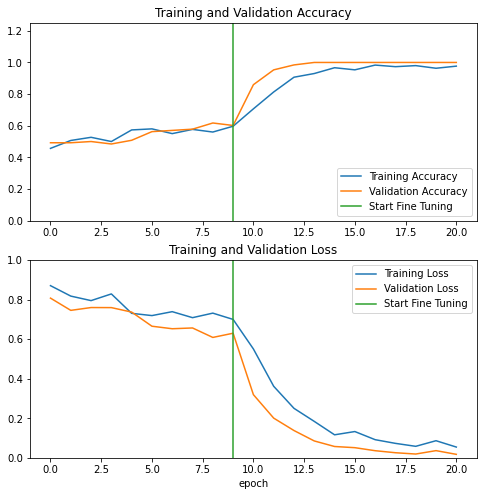

In [128]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.25])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [129]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 83ms/step - loss: 0.1096 - accuracy: 0.9500
Test accuracy : 0.949999988079071


Predictions:
 [1 0 1 0 0 0 0 1 1 1 1 1]
Labels:
 [1 0 1 0 0 0 0 1 1 1 0 1]


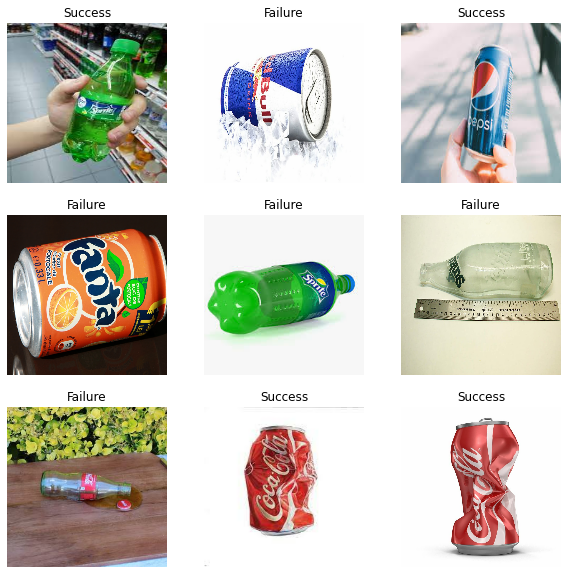

In [130]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [131]:
model.save('TrashCNN.h5')